In [1]:
## CLASS IMPORT

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_recall_fscore_support
from scipy.optimize import curve_fit
from sklearn.utils import shuffle
import numpy as np
import pylab as py
import os
import random

In [2]:
## OUTPUT FUNCTION FOR IGOR

def generate_igor(x_label, x_data, y_label, y_data, plot_save):
    """ (list, list, list, list, str) -> None
    Given lists of x-axis labels, x-axis data, y-axis labels, and y-axis data,
    generate Igor text file with plot_save name.
    """
    # Don't do anything if given empty entries.
    if x_label == [] and x_data == [] and y_label == [] and y_data == []:
        return None
    
    # change .png to .itx
    igor_save = plot_save[:-3]+'itx'
    data = open(igor_save, 'w')

    # put \' around all labels
    for L in [x_label, y_label]:
        for i in range(len(L)): L[i] = '\''+L[i]+'\''

    # WRITE LINES: (note figure = '\r')
    # 1. Setup
    s_return = ''                   # line to be written in Igor file
    s_return += 'IGOR\rWAVES/D\t'   # header
    # 2. Label
    s_label = '\t'.join(str(e) for e in x_label)+'\t'
    s_label += '\t'.join(str(e) for e in y_label)
    s_return += s_label
    s_return += '\rBEGIN\r'
    # 3. Data
    # combine x_data and y_data into one list
    if type(x_data) != list: x_data = np.ndarray.tolist(x_data) # change format
    if type(y_data) != list: y_data = np.ndarray.tolist(y_data) # change format
    L_data = x_data+y_data
    # get list of lengths of each data list, both x and y
    L_size = []
    for i in range(len(L_data)): L_size.append(len(L_data[i]))
    # register data
    max_i = max(L_size)
    length = len(L_size)
    i = 0
    while i < max_i:
        s_i = ''
        for j in range(length):
            if L_size[j] > i and L_data[j][i] != None:
                s_i += '\t'+str(L_data[j][i])
            else: s_i += '\tNAN'
        s_return += s_i+'\r'
        i += 1
    s_return += 'END'
    data.write(s_return)
    data.close()
    return None

In [3]:
## DIRECTORY SETTINGS, GLOBAL VARIABLE SETTINGS, AND GENERAL FUNCTIONS

main_dir = os.getcwd()+r'\\'
data_name = main_dir+'match_vectors_no_label.csv'

K = 3   # number of classes = 3 (-1, 0, 1)
LABEL = [-1, 0, 1]  # labels of y
LABEL_LEGEND = ['loss', 'draw', 'win']
FEATURE_LABEL = ['h_roster_rating',
                 'h_gk_rating',
                 'h_def_rating',
                 'h_mid_rating',
                 'h_off_rating',
                 'a_roster_rating',
                 'a_gk_rating',
                 'a_def_rating',
                 'a_mid_rating',
                 'a_off_rating',
                 'label']
FIGURE_SIZE = (8, 10)
TEXT_SIZE = 10
DPI = 150

def add_x0(x):
    """ (np.matrix) -> np.matrix
    Add 1's in the 0th column to the given matrix x.
    """
    return_x = np.zeros((x.shape[0], x.shape[1] + 1))
    return_x[:,0] = 1
    return_x[:,1:] = x
    return return_x

def define_xy(data, L_i, ratio=0.8, add_zero=True):
    """ (np.matrix, list of int) -> np.matrix, np.array, np.matrix, np.array
    Given the imported data matrix, generate input feature matrix x and label
    array y, with the desired input features indicated by index list L_i. Add
    intercepts 1 to x. Split x and y into training and test sets according to
    [training:test = 'ratio':1-'ratio'].
    """
    if add_zero: x = add_x0(data[:,L_i])
    else: x = data[:,L_i]
    y = data[:,-1]
    i_split = int(len(y)*ratio)
    x_train, x_test = x[:i_split,:], x[i_split:,:]
    y_train, y_test = y[:i_split], y[i_split:]
    return x_train, y_train, x_test, y_test

def arrange_data(file_name, L_i):
    data = np.genfromtxt(shuffled_data_name, delimiter=',')
    x_train, y_train, x_test, y_test = define_xy(data, L_i, ratio=0.8,
                                                add_zero=False)
    # split data set to win/loss & draw
    x_train_logreg, y_train_logreg = add_x0(x_train[y_train != 0]), y_train[y_train != 0]
    x_test_logreg, y_test_logreg = add_x0(x_test[y_test != 0]), y_test[y_test != 0]
    x_train_gaussian, y_train_gaussian = x_train[y_train == 0], y_train[y_train == 0]
    x_test_gaussian, y_test_gaussian = x_test[y_test == 0], y_test[y_test == 0]
    return x_train, y_train, x_test, y_test, x_train_logreg, y_train_logreg,\
           x_test_logreg, y_test_logreg, x_train_gaussian, y_train_gaussian,\
           x_test_gaussian, y_test_gaussian

def Gaussian(X, mu, sigma, matrix=True):
    if matrix:
        return_x = []
        for i in range(X.shape[0]):
            x = X[i,:]
            return_x.append(((2*np.pi)**(len(mu)/2.)*np.linalg.det(sigma)**0.5)**-1 *\
                            np.exp(-0.5*(x-mu).dot(np.linalg.inv(sigma)).dot(x-mu)))
        return return_x
    else:
        return ((2*np.pi)**(len(mu)/2.)*np.linalg.det(sigma)**0.5)**-1 *\
                np.exp(-0.5*(X-mu).dot(np.linalg.inv(sigma)).dot(X-mu))

#https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py
def make_meshgrid(x, y, limit=None, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    if limit == None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = limit
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [4]:
# FUNCTION BLOCK FOR SVM
def plot_SVM(x0, x1, SVM_type, x, y, x_train, y_train, d_feature, n_poly=3, title=None, figsize=FIGURE_SIZE, dpi=DPI,
             plot_range=[6.1,7.7,6.1,7.7]):
    # decide on kernel
    if SVM_type == 'linear': clf = SVC(kernel='linear')
    elif SVM_type == 'rbf': clf = SVC(kernel='rbf')
    elif SVM_type == 'poly': clf = SVC(kernel='poly', degree=n_poly)
    elif SVM_type == 'sigmoid': clf = SVC(kernel='sigmoid')
    # do the fit
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x)
    # calculate overall accuracy
    match = (y_predict == y)*1
    accuracy = np.sum(match)*1./len(match)
    # calculate precision: i.e. individual accuracy
    L_win_true = (y_predict[y_predict == 1] == y[y_predict == 1])*1
    p_win = np.sum(L_win_true)*1./len(L_win_true)
    L_draw_true = (y_predict[y_predict == 0] == y[y_predict == 0])*1
    p_draw = np.sum(L_draw_true)*1./len(L_draw_true)
    L_loss_true = (y_predict[y_predict == -1] == y[y_predict == -1])*1
    p_loss = np.sum(L_loss_true)*1./len(L_loss_true)
    # calculate recall: i.e. how much of each category we can predict correctly
    r_win = np.sum(y_predict[y_predict == 1] == y[y_predict == 1])*1./np.sum(y == 1)
    r_draw = np.sum(y_predict[y_predict == 0] == y[y_predict == 0])*1./np.sum(y == 0)
    r_loss = np.sum(y_predict[y_predict == -1] == y[y_predict == -1])*1./np.sum(y == -1)
    # print statistics
    print('Overall Accuracy: '+str(accuracy))
    print('Win/Draw/Loss Precision: '+str([p_win, p_draw, p_loss]))
    print('Win/Draw/Loss Recall: '+str([r_win, r_draw, r_loss]))
    # now, plot:
    fig, ax = py.subplots(2, 2, figsize=figsize, dpi=dpi)
    for i in range(2):
        for j in range(2):
#                for k in range(len(M_theta)): ax[i,j].plot(decision_x[k], decision_y[k], ':')
#            ax[i,j].set_xlim(plot_range[0], plot_range[1])
#            ax[i,j].set_ylim(plot_range[2], plot_range[3])
            ax[i,j].set_xlabel('home_average_rating')
            ax[i,j].set_ylabel('away_average_rating')
    # row 1 column 1: plot predicted values
    ax[0,0].title.set_text('total prediction')
    ax[0,0].scatter(x0, x1, c=y_predict, cmap=py.cm.coolwarm, s=20, edgecolors='k')
    # row 1 column 2: plot actual values
    ax[0,1].title.set_text('actual values')
    ax[0,1].scatter(x0, x1, c=y, cmap=py.cm.coolwarm, s=20, edgecolors='k')
    # row 2 column 1: plot correctly predicted points
    ax[1,0].title.set_text('correct predictions')
    ax[1,0].scatter(x0[y_predict == y], x1[y_predict == y], c=y[y_predict == y],
                    cmap=py.cm.coolwarm, s=20, edgecolors='k')
    # row 2 column 2: plot incorrectly predicted points
    ax[1,1].title.set_text('incorrect predictions')
    ax[1,1].scatter(x0[y_predict != y], x1[y_predict != y], c=y[y_predict != y],
                    cmap=py.cm.coolwarm, s=20, edgecolors='k')
    # set title and save if requested
    if title != None:
        fig.suptitle(title)
        py.savefig(title+'.png')
        # save in igor file
        generate_igor(['x0', 'x0_win', 'x0_draw', 'x0_loss', 'x0_correct', 'x0_wrong',\
                       'x1', 'x1_win', 'x1_draw', 'x1_loss', 'x1_correct', 'x1_wrong'],
                      [x0, x0[y == 1], x0[y == 0], x0[y == -1], x0[y_predict == y], x0[y_predict != y],\
                       x1, x1[y == 1], x1[y == 0], x1[y == -1], x1[y_predict == y], x1[y_predict != y]],
                      ['y_label', 'y_predict', 'y_predict_correct', 'y_predict_wrong'],
                      [y+1, y_predict+1, y[y_predict == y]+1, y[y_predict != y]+1],
                      title+'.png')
    py.show()
    py.close()
    return y, y_predict

In [5]:
# CHOOSE FEATURES

if __name__ == '__main__':
    # import data
    # import data after specifying which features to use
    ratio = 0.8
    data_name = main_dir+'match_vectors_extended.csv' # removed zero-entry arrays to avoid singular matrix in GDA
    data = shuffle(np.genfromtxt(data_name, delimiter=',',skip_header=1), random_state=0)
    x = data[:,:-1]
    y = data[:,-1]
    
    # get roster rating for plots
    data_roster_name = main_dir+'match_vectors.csv'
    data_roster = shuffle(np.genfromtxt(data_roster_name, delimiter=',',skip_header=1), random_state=0)
    x0 = data_roster[:,0]
    x1 = data_roster[:,1]
    
    #X_quadratic_features=gen_quadratic_features(X)
    #print()
    i_split = int(len(y)*ratio)
    L_feature = range(x.shape[0]) # features to choose

In [9]:
    # SET UP TRAINING & TEST SETS

    x_train = x[:i_split,:]
    y_train = y[:i_split]
    x_test = x[i_split:,:]
    y_test = y[i_split:]
"""
    x_train_logreg = add_x0(x_train)
    x_test_logreg = add_x0(x_test)
    y_train_logreg = np.copy(y_train)
    y_test_logreg = np.copy(y_test)
    x_train_gaussian = np.copy(x_train)
    x_test_gaussian = np.copy(x_test)
    y_train_gaussian = np.copy(y_train)
    y_test_gaussian = np.copy(y_test)
"""
    x0_train = x0[:i_split]
    x1_train = x1[:i_split]
    x0_test = x0[i_split:]
    x1_test = x1[i_split:]

    # create a dictionary linking original feature_i to subset feature_i (i.e. L_feature)
    d_feature = {}
    for i in range(len(L_feature)): d_feature[L_feature[i]] = i

C:\Users\Kyuho\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Overall Accuracy: 1.0
Win/Draw/Loss Precision: [1.0, 1.0, 1.0]
Win/Draw/Loss Recall: [1.0, 1.0, 1.0]


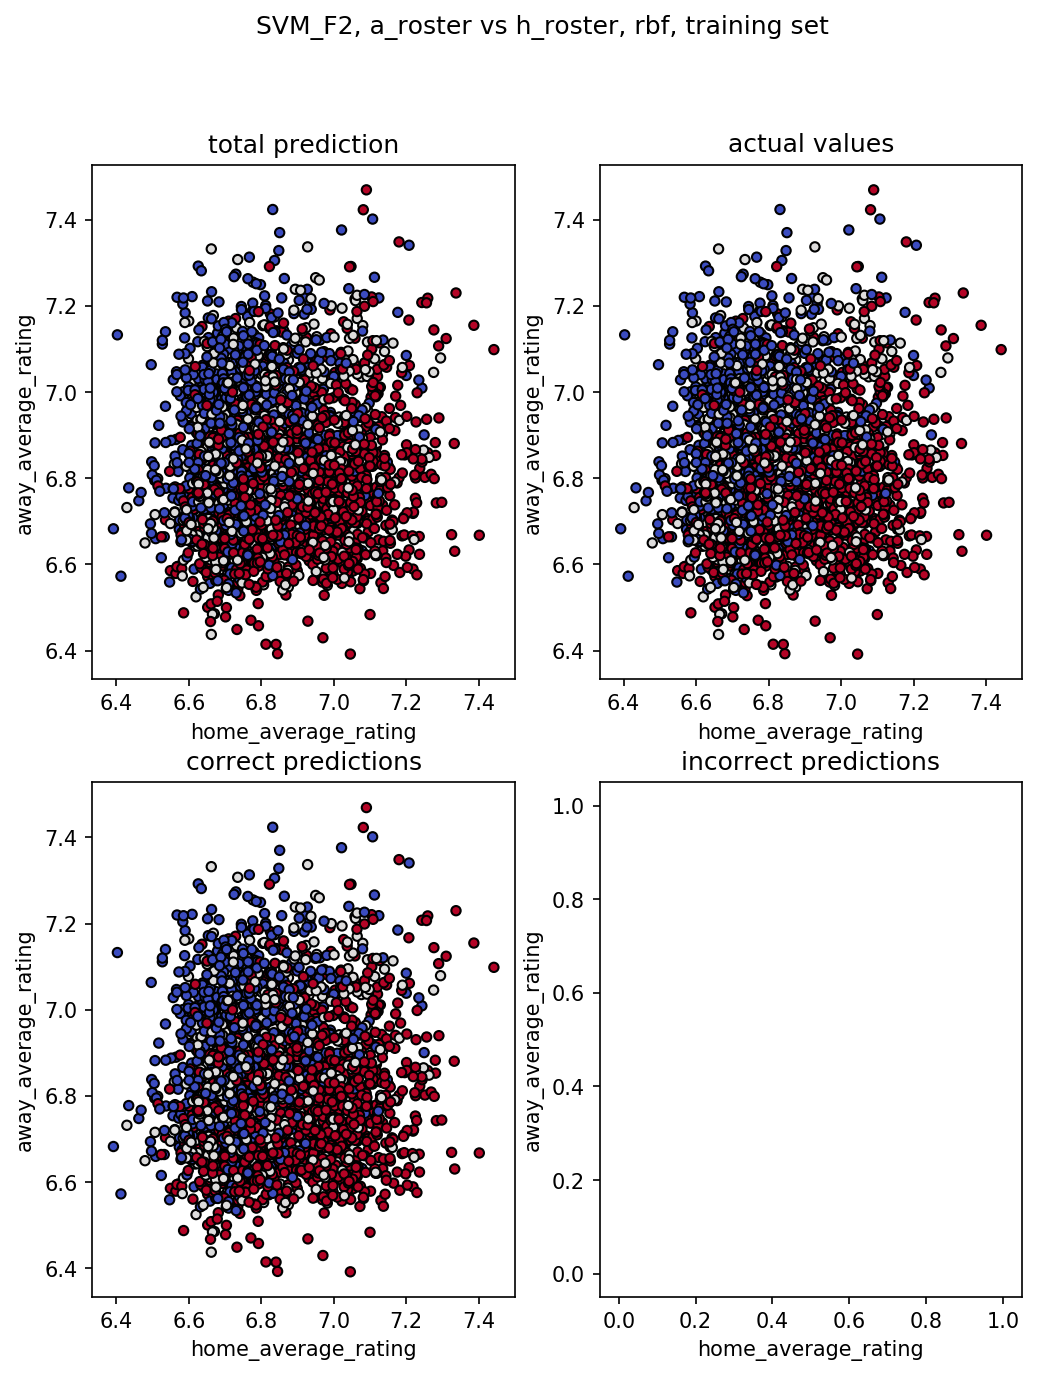

C:\Users\Kyuho\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Kyuho\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kyuho\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Overall Accuracy: 0.46772068511198944
Win/Draw/Loss Precision: [0.46772068511198944, nan, nan]
Win/Draw/Loss Recall: [1.0, 0.0, 0.0]


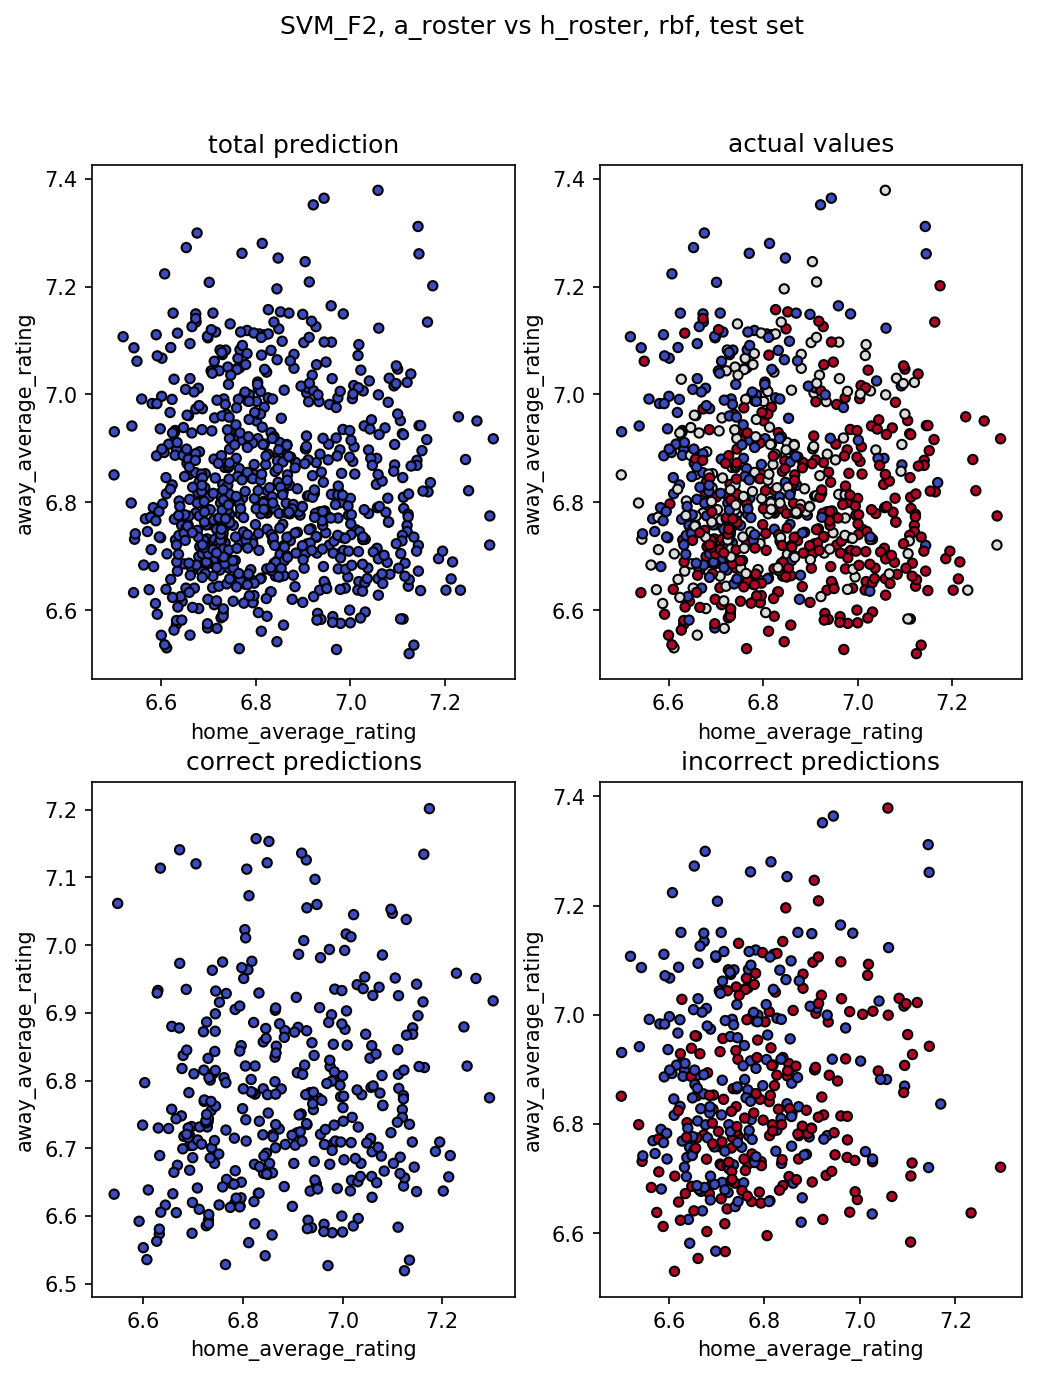

In [63]:
    # SVM with RBF kernel
    # on training set
    y_SVM_rbf_train, y_predict_SVM_rbf_train = plot_SVM(x0_train, x1_train, 'rbf',\
                                                        x_train, y_train, x_train, y_train, d_feature,
                                                        title='SVM_F3, a_roster vs h_roster, rbf, training set')
    # on test set
    y_SVM_rbf_test, y_predict_SVM_rbf_test = plot_SVM(x0_test, x1_test, 'rbf',\
                                                      x_test, y_test, x_train, y_train, d_feature,
                                                      title='SVM_F3, a_roster vs h_roster, rbf, test set')

Overall Accuracy: 0.6503957783641161
Win/Draw/Loss Precision: [0.6898656898656899, 0.5540540540540541, 0.6273684210526316]
Win/Draw/Loss Recall: [0.8094555873925502, 0.3293172690763052, 0.6704161979752531]


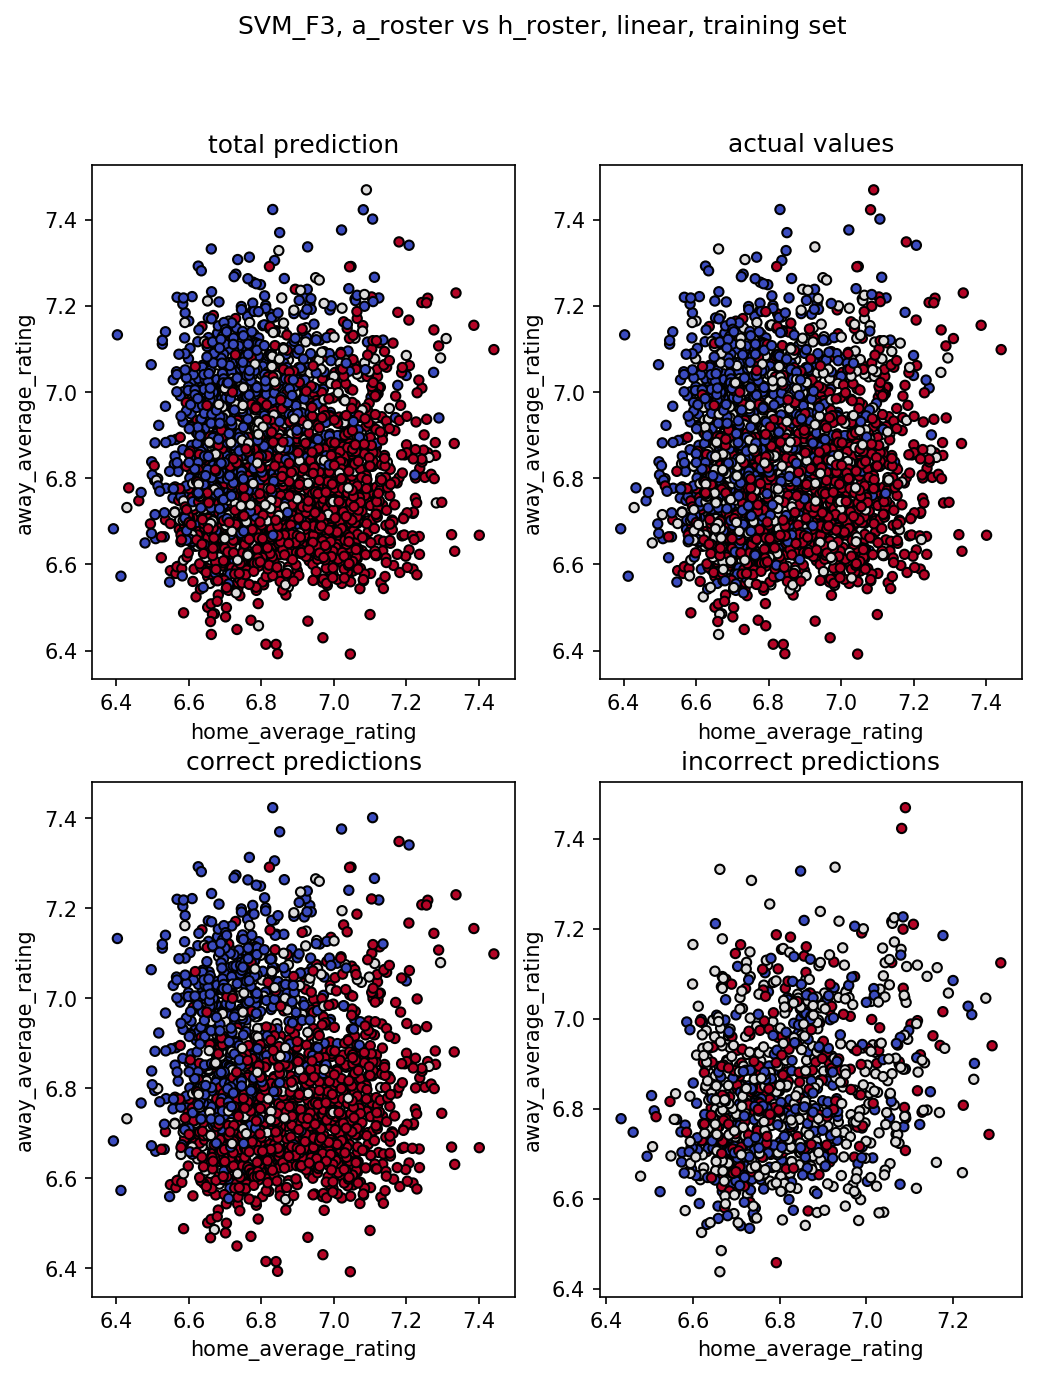

Overall Accuracy: 0.544137022397892
Win/Draw/Loss Precision: [0.6098130841121495, 0.34615384615384615, 0.5110132158590308]
Win/Draw/Loss Recall: [0.7352112676056338, 0.18652849740932642, 0.5497630331753555]


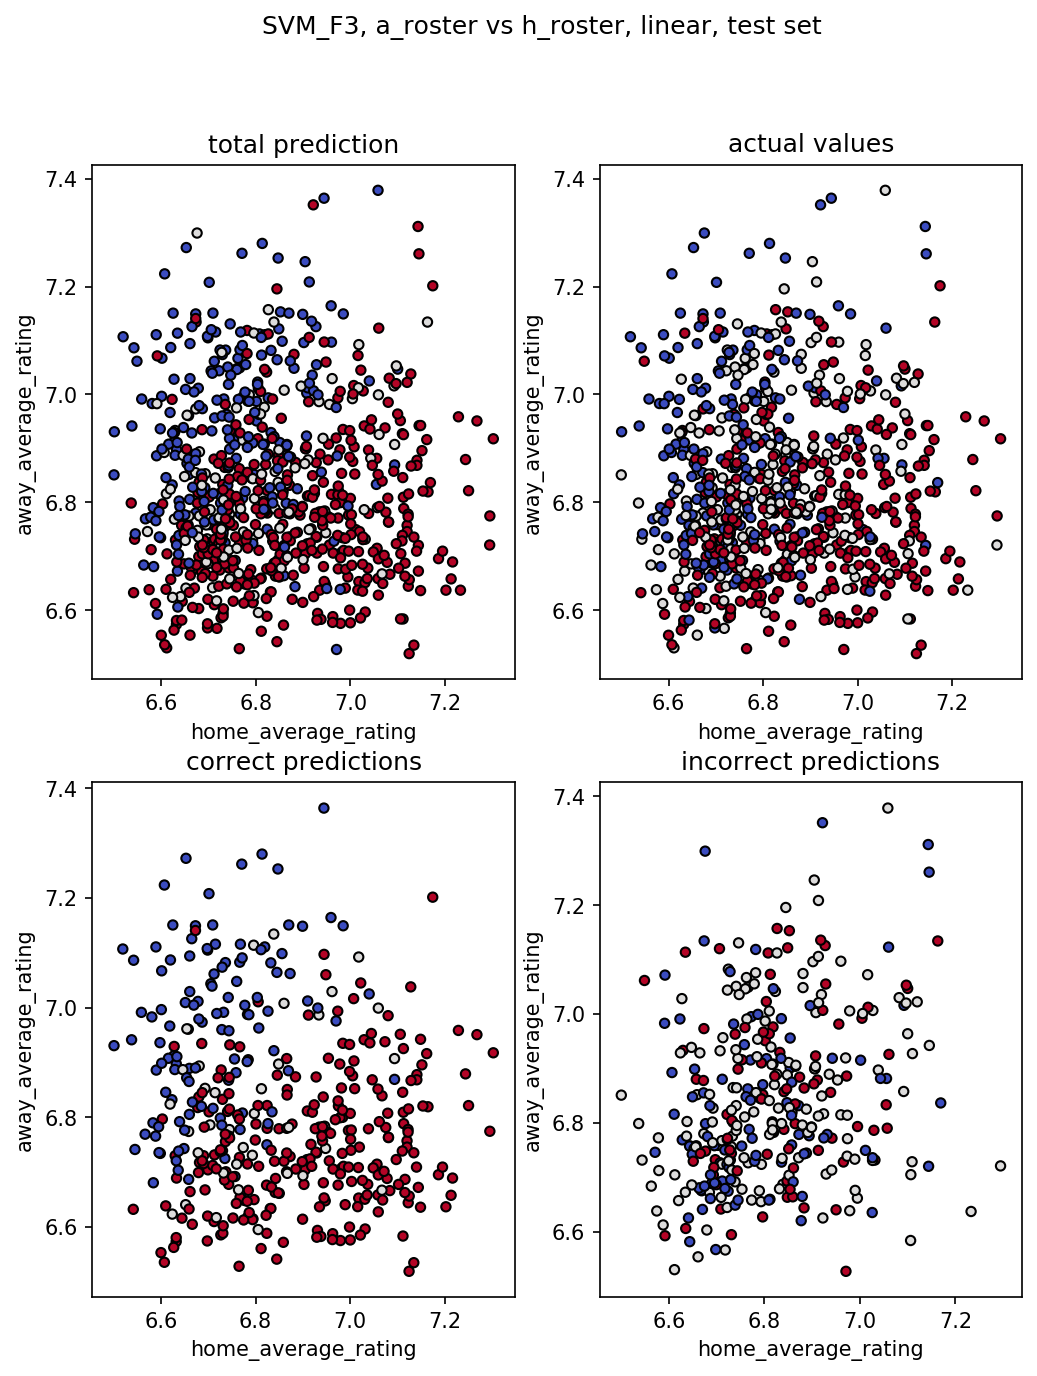

In [8]:
    # SVM with linear kernel
    # on training set
    y_SVM_linear_train, y_predict_SVM_linear_train = plot_SVM(x0_train, x1_train, 'linear',\
                                                              x_train, y_train, x_train, y_train, d_feature,
                                                              title='SVM_F3, a_roster vs h_roster, linear, training set')
    # on test set
    y_SVM_linear_test, y_predict_SVM_linear_test = plot_SVM(x0_test, x1_test, 'linear',\
                                                            x_test, y_test, x_train, y_train, d_feature,
                                                            title='SVM_F3, a_roster vs h_roster, linear, test set')

C:\Users\Kyuho\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Overall Accuracy: 1.0
Win/Draw/Loss Precision: [1.0, 1.0, 1.0]
Win/Draw/Loss Recall: [1.0, 1.0, 1.0]


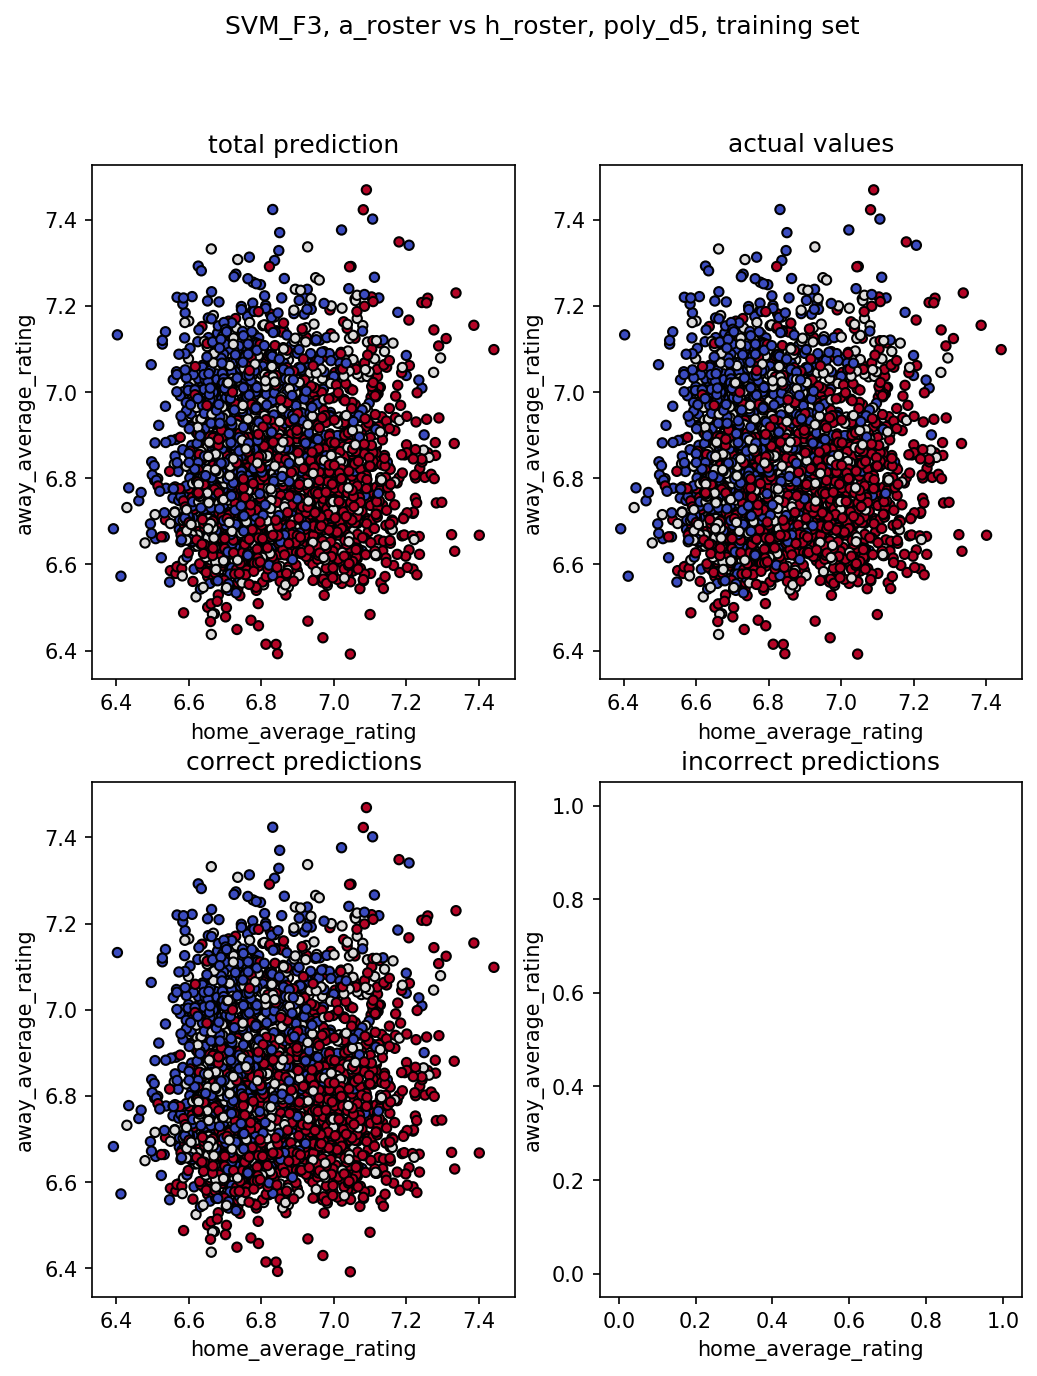

C:\Users\Kyuho\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Overall Accuracy: 0.47035573122529645
Win/Draw/Loss Precision: [0.5918367346938775, 0.28823529411764703, 0.4268292682926829]
Win/Draw/Loss Recall: [0.571830985915493, 0.2538860103626943, 0.4976303317535545]


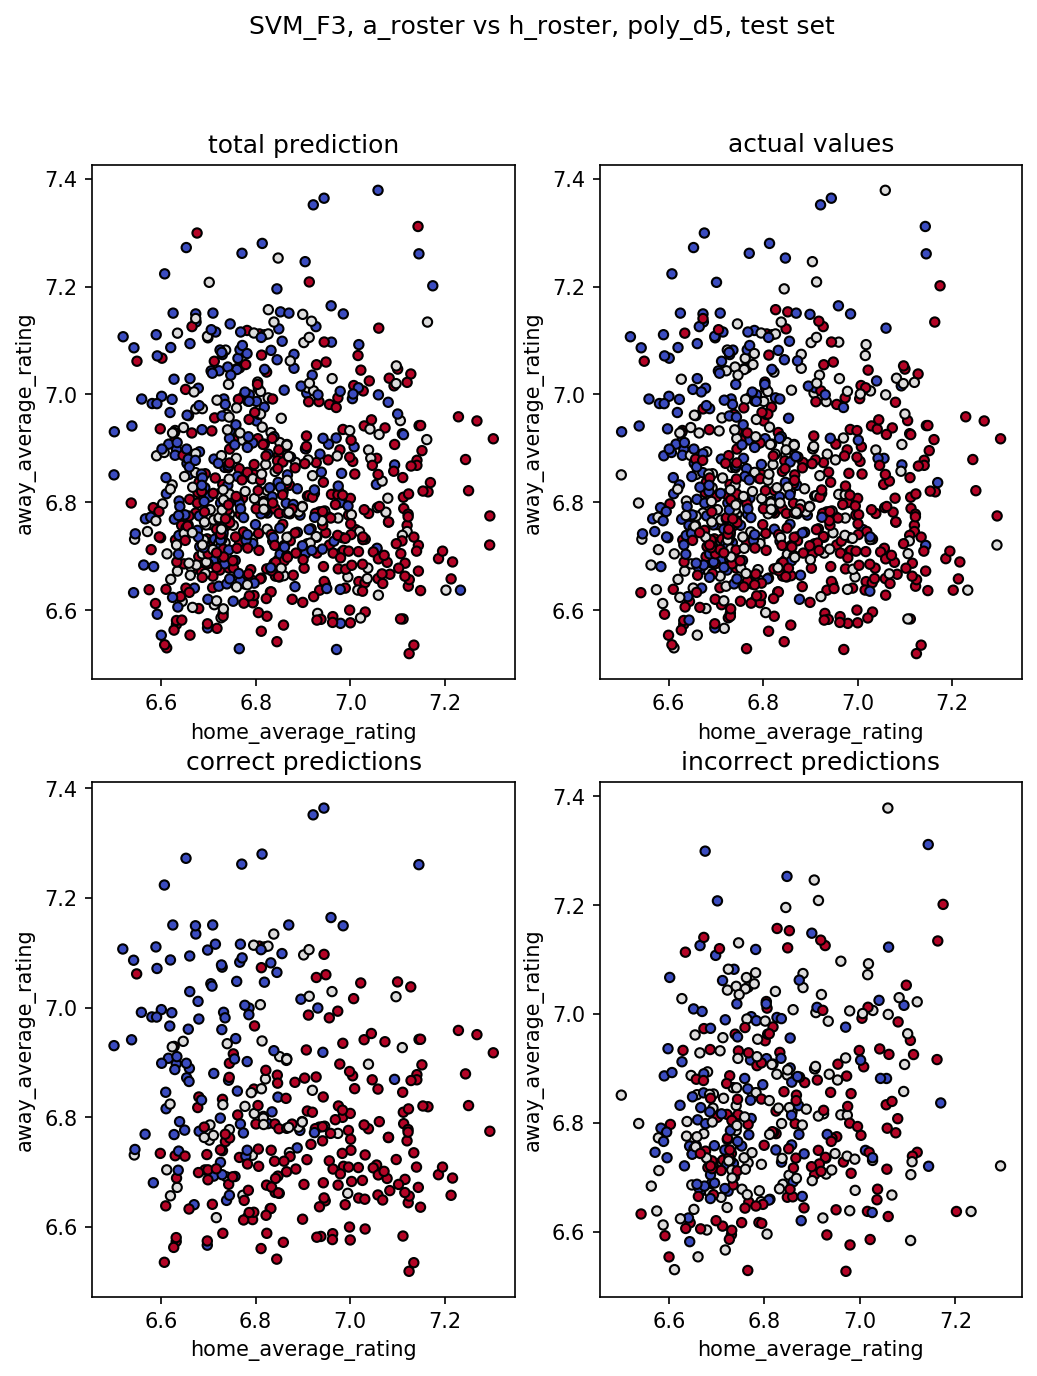

In [7]:
    # SVM with polynomial kernel
    # on training set
    y_SVM_poly5_train, y_predict_SVM_poly5_train = plot_SVM(x0_train, x1_train, 'poly',\
                                                            x_train, y_train, x_train, y_train, d_feature, n_poly=5,
                                                            title='SVM_F3, a_roster vs h_roster, poly_d5, training set')
    # on test set
    y_SVM_poly5_train, y_predict_SVM_poly5_train = plot_SVM(x0_test, x1_test, 'poly',\
                                                            x_test, y_test, x_train, y_train, d_feature, n_poly=5,
                                                            title='SVM_F3, a_roster vs h_roster, poly_d5, test set')